In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb
import re
import optuna

In [186]:
pd.set_option('display.max_columns', None)

In [187]:
train_df = pd.read_csv('data/train.csv')
train_df.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [188]:
test_df = pd.read_csv('data/test.csv')
test_df.head(5)

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

# EDA

In [189]:
train_df[['Survived', 'Embarked']].groupby('Embarked').mean()

Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957

# Feature Engineering

In [190]:
train_df['Sex'] = train_df['Sex'].map({'male' : 0, 'female' : 1})
test_df['Sex'] = test_df['Sex'].map({'male' : 0, 'female' : 1})

In [191]:

train_df['Title'] = train_df['Name'].str.extract(r'(Mr\.|Mrs\.|Ms\.|Miss|Dr\.|Rev\.)')
test_df['Title'] = test_df['Name'].str.extract(r'(Mr\.|Mrs\.|Ms\.|Miss|Dr\.|Rev\.)')

train_df = pd.get_dummies(train_df, columns = ['Title'])
test_df = pd.get_dummies(test_df, columns = ['Title'])


In [192]:
train_df = pd.get_dummies(train_df, columns = ['Embarked'])
test_df = pd.get_dummies(test_df, columns = ['Embarked'])

In [193]:
title_one_hot = [col for col in train_df.columns if col.startswith('Title_')]
title_one_hot

['Title_Dr.',
 'Title_Miss',
 'Title_Mr.',
 'Title_Mrs.',
 'Title_Ms.',
 'Title_Rev.']

In [194]:
embarked_one_hot = [col for col in train_df.columns if col.startswith('Embarked_')]
embarked_one_hot

['Embarked_C', 'Embarked_Q', 'Embarked_S']

In [195]:
train_df['Is_Baby'] = train_df['Age'] <= 3
test_df['Is_Baby'] = test_df['Age'] <= 3

## Age Imputation

In [196]:
def impute_age(df):

    assert df['Age'].isnull().sum() > 0, 'No null values'
    age_df = df.copy()

    age_known = age_df[age_df['Age'].notnull()]
    age_missing = age_df[age_df['Age'].isnull()]

    features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare'] + title_one_hot + embarked_one_hot 

    X_train = age_known[features]
    y_train = age_known['Age']


    X_pred = age_missing[features]


    model = RandomForestRegressor(n_estimators = 100, random_state = 0)

    model.fit(X_train, y_train)

    age_df.loc[age_df['Age'].isnull(), 'Age'] = model.predict(X_pred)
    return age_df['Age']

In [197]:
train_df['Age Missing'] = train_df['Age'].isnull().astype(int)
test_df['Age Missing'] = test_df['Age'].isnull().astype(int)

In [198]:
train_df['Age'] = impute_age(train_df)
test_df['Age'] = impute_age(test_df)

## Fare Imputation

In [199]:
train_df.loc[train_df['Fare'] == 0, 'Fare'] = np.nan
test_df.loc[test_df['Fare'] == 0, 'Fare'] = np.nan

In [200]:
def impute_fare(df):

    assert df['Fare'].isnull().sum() > 0, 'No null values'
    fare_df = df.copy()

    fare_known = fare_df[fare_df['Fare'].notnull()]
    fare_missing = fare_df[fare_df['Fare'].isnull()]

    features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare'] + title_one_hot + embarked_one_hot 

    X_train = fare_known[features]
    y_train = fare_known['Fare']


    X_pred = fare_missing[features]


    model = RandomForestRegressor(n_estimators = 100, random_state = 0)

    model.fit(X_train, y_train)

    fare_df.loc[fare_df['Fare'].isnull(), 'Fare'] = model.predict(X_pred)
    return fare_df['Fare']

In [201]:
train_df['Fare Missing'] = train_df['Fare'].isnull().astype(int)
test_df['Fare Missing'] = test_df['Fare'].isnull().astype(int)

In [202]:
train_df['Fare'] = impute_fare(train_df)
test_df['Fare'] = impute_fare(test_df)

In [203]:
train_df['Fare_Per_Person'] = train_df['Fare'] / (1 + train_df['SibSp'] + train_df['Parch'])
test_df['Fare_Per_Person'] = test_df['Fare'] / (1 + test_df['SibSp'] + test_df['Parch'])

In [204]:
features = ['Pclass', 'Sex', 'Age', 'Age Missing', 'SibSp', 'Parch', 'Fare', 'Fare_Per_Person', 'Is_Baby'] + title_one_hot + embarked_one_hot

In [205]:
df = train_df[['Survived'] + features]
df

Survived  Pclass  Sex     Age  Age Missing  SibSp  Parch     Fare  \
0           0       3    0  22.000            0      1      0   7.2500   
1           1       1    1  38.000            0      1      0  71.2833   
2           1       3    1  26.000            0      0      0   7.9250   
3           1       1    1  35.000            0      1      0  53.1000   
4           0       3    0  35.000            0      0      0   8.0500   
..        ...     ...  ...     ...          ...    ...    ...      ...   
886         0       2    0  27.000            0      0      0  13.0000   
887         1       1    1  19.000            0      0      0  30.0000   
888         0       3    1   6.363            1      1      2  23.4500   
889         1       1    0  26.000            0      0      0  30.0000   
890         0       3    0  32.000            0      0      0   7.7500   

     Fare_Per_Person  Is_Baby  Title_Dr.  Title_Miss  Title_Mr.  Title_Mrs.  \
0            3.62500    False      False       False       True       False   
1           35.64165    False      False       False      False        True   
2            7.92500    False      False        True      False       False   
3           26.55000    False      False       False      False        True   
4            8.05000    False      False       False       True       False   
..               ...      ...        ...         ...        ...         ...   
886         13.00000    False      False       False      False       False   
887         30.00000    False      False        True      False       False   
888          5.86250    False      False        True      False       False   
889         30.00000    False      False       False       True       False   
890          7.75000    False      False       False       True       False   

     Title_Ms.  Title_Rev.  Embarked_C  Embarked_Q  Embarked_S  
0        False       False       False       False        True  
1        False       False        True       False       False  
2        False       False       False       False        True  
3        False       False       False       False        True  
4        False       False       False       False        True  
..         ...         ...         ...         ...         ...  
886      False        True       False       False        True  
887      False       False       False       False        True  
888      False       False       False       False        True  
889      False       False        True       False       False  
890      False       False       False        True       False  

[891 rows x 19 columns]

# Training

In [206]:
X = df[features]
y = df['Survived']

In [207]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Random Forest

In [208]:
model = RandomForestClassifier(random_state = 0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [209]:
y_pred = model.predict(X_val)

In [210]:
print('Accuracy: ', accuracy_score(y_val, y_pred))

Accuracy:  0.8379888268156425


## XGBoost

In [211]:
folder = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

In [212]:
xgb_model = xgb.XGBClassifier(
    use_label_encoder = False,
    eval_metric='logloss', 
    random_state=42  
)

In [213]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}


In [214]:
grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = param_grid,
    cv = folder,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = 1

)

In [215]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:22:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:22:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:22:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/train

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_p...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [216]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}

In [217]:
grid_search.best_score_

np.float64(0.8356544863587118)

In [218]:
best_xgb_model = grid_search.best_estimator_

In [219]:
val_preds = best_xgb_model.predict(X_val)
print(accuracy_score(y_val, val_preds))

0.7932960893854749


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

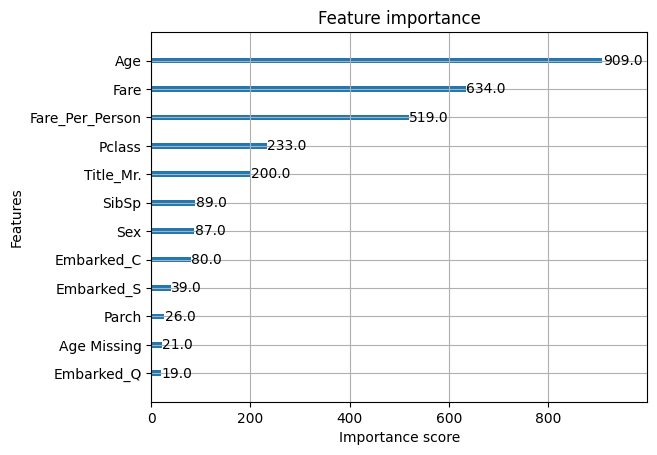

In [220]:
xgb.plot_importance(best_xgb_model, max_num_features = len(train_df.columns))

# Light GBM

In [302]:

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
lgb_model.fit(X_train, y_train)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=500,
               random_state=42)

In [313]:
y_pred = lgb_model.predict(X_val)
accuracy_score(y_pred, y_val)

0.8715083798882681

# Submission

In [225]:
MODEL_CHOICE = best_xgb_model

In [226]:
VERSION = '_v4_xgb'

In [227]:
test_features = test_df[features]

In [228]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': MODEL_CHOICE.predict(test_features)
})
submission.to_csv('submission' + VERSION + '.csv', index=False)